In [100]:
import pandas as pd
import numpy as np

In [101]:
df = pd.read_csv('..\sell-in.txt',sep='\t')

In [102]:
prod_a_predecir = pd.read_csv('..\productos_a_predecir.txt', sep='\t')
prod_data = pd.read_csv('../tb_productos.txt', sep='\t')
stock_data = pd.read_csv('../tb_stocks.txt', sep='\t')

In [103]:
for col in prod_data.select_dtypes(include=['object']).columns:
    prod_data[col] = prod_data[col].astype('category')

prod_data = prod_data.drop_duplicates(subset='product_id')

In [104]:
df_grouped = df.groupby(['periodo', 'product_id']).sum().reset_index()

In [105]:
df_grouped = df_grouped[['product_id', 'periodo', 'tn']]
df_grouped.sort_values(by=['product_id', 'periodo'], inplace=True)
df_grouped.reset_index(drop=True, inplace=True)

In [106]:
print(df_grouped.shape)
df_grouped.head()

(31243, 3)


,product_id,periodo,tn
0,20001,201701,934.77222
1,20001,201702,798.01620
2,20001,201703,1303.35771
3,20001,201704,1069.96130
4,20001,201705,1502.20132


In [107]:
prod_stats = df_grouped.groupby('product_id').apply(lambda group: pd.Series({
    'primer_periodo': group['periodo'].min(),
    'ultimo_periodo': group['periodo'].max(),
    'values': group['tn'].count(),
    'total_tn': group['tn'].sum(),
    'min_tn': group['tn'].min(),
    'average_tn': group['tn'].mean(),
    'median_tn': group['tn'].median(),
    'std_dev_tn': group['tn'].std(),
    'iqr_tn': (group['tn'].quantile(0.75) - group['tn'].quantile(0.25)),
    'max_tn': group['tn'].max()
}))
prod_stats['primer_periodo'] = prod_stats['primer_periodo'].astype(int)
prod_stats['primer_periodo'] = pd.to_datetime(prod_stats['primer_periodo'].astype(str), format='%Y%m')

prod_stats['ultimo_periodo'] = prod_stats['ultimo_periodo'].astype(int)
prod_stats['ultimo_periodo'] = pd.to_datetime(prod_stats['ultimo_periodo'].astype(str), format='%Y%m')

prod_stats.reset_index(inplace=True)

In [108]:
prod_stats = prod_stats[prod_stats['product_id'].isin(prod_a_predecir['product_id'])]
df_grouped = df_grouped[df_grouped['product_id'].isin(prod_a_predecir['product_id'])]

In [109]:
print(prod_stats.shape)
prod_stats.head()

(780, 11)


,product_id,primer_periodo,ultimo_periodo,values,total_tn,min_tn,average_tn,median_tn,std_dev_tn,iqr_tn,max_tn
0,20001,2017-01-01,2019-12-01,36.0,50340.39558,798.01620,1398.344322,1418.023430,298.145460,335.515348,2295.19832
1,20002,2017-01-01,2019-12-01,36.0,36337.25439,505.88633,1009.368178,992.005505,303.834835,246.766150,1979.53635
2,20003,2017-01-01,2019-12-01,36.0,32004.15274,525.82591,889.004243,786.715735,292.036581,260.440887,1958.59845
3,20004,2017-01-01,2019-12-01,36.0,24178.15379,415.52538,671.615383,596.909300,224.450085,279.662265,1268.21209
4,20005,2017-01-01,2019-12-01,36.0,23191.21852,329.42894,644.200514,578.571990,218.273222,305.415543,1247.88880


In [110]:
df_grouped.to_parquet('sell_in_group.parquet', index=False)
prod_stats.to_parquet('prod_stats.parquet', index=False)
prod_data.to_parquet('prod_data.parquet', index=False)
stock_data.to_parquet('stock_data.parquet', index=False)

In [111]:
import matplotlib.pyplot as plt

In [112]:
dibujo = pd.DataFrame(df_grouped['tn'].groupby(df_grouped['periodo']).aggregate('mean')).reset_index()
dibujo['fecha'] = pd.to_datetime(dibujo['periodo'].astype(str), format='%Y%m')
dibujo.head()

,periodo,tn,fecha
0,201701,54.836658,2017-01-01
1,201702,54.827691,2017-02-01
2,201703,73.167157,2017-03-01
3,201704,62.153104,2017-04-01
4,201705,70.767490,2017-05-01


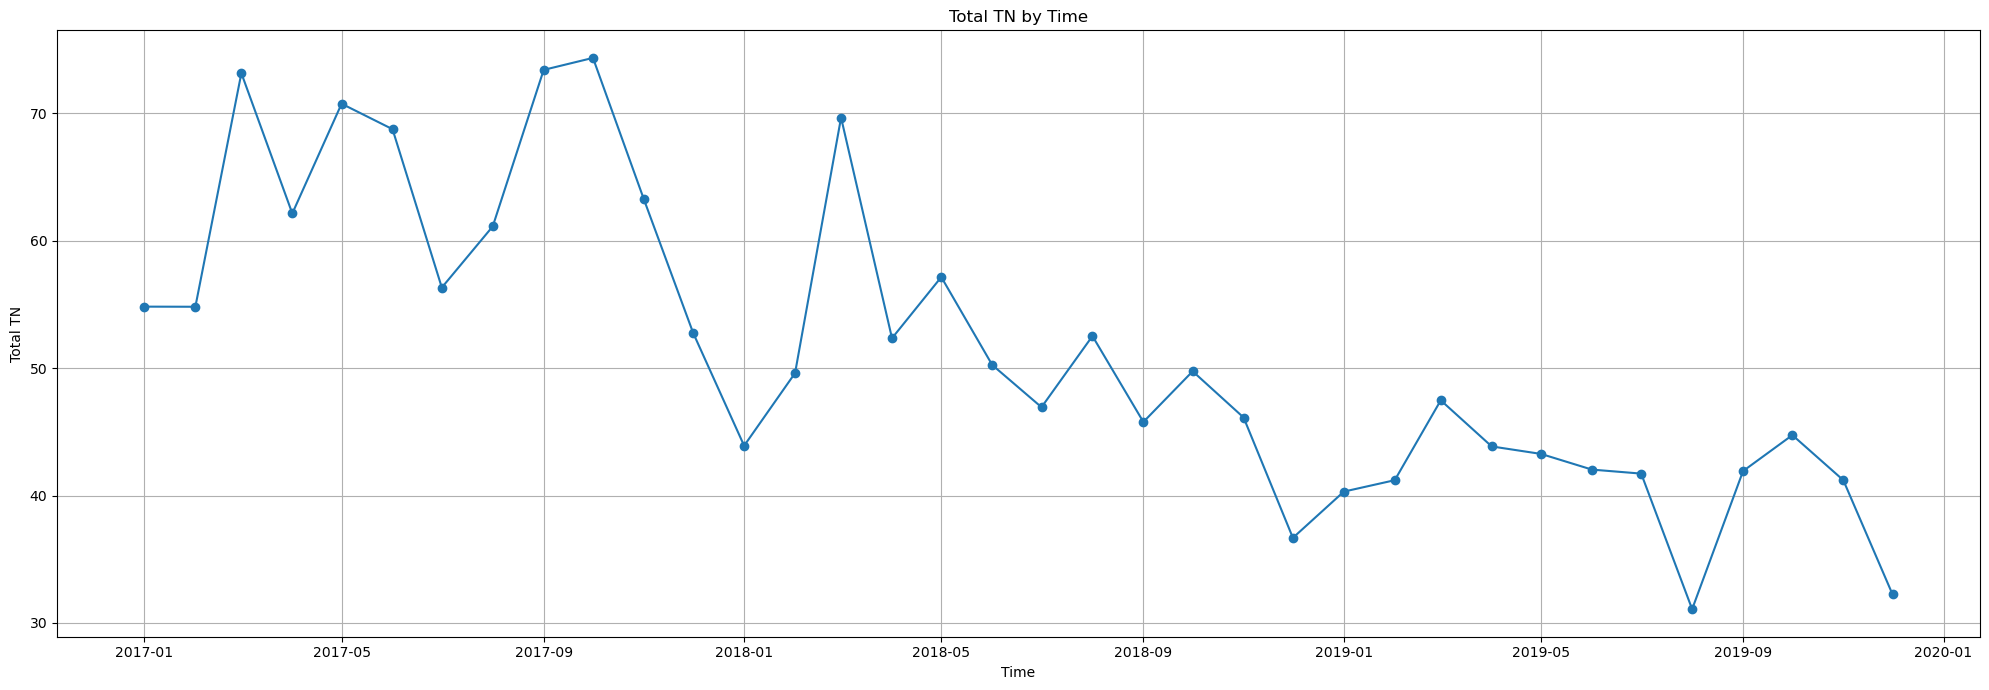

In [113]:
plt.figure(figsize=(20, 7))
plt.plot(dibujo['fecha'], dibujo['tn'], marker='o')
plt.title('Total TN by Time')
plt.xlabel('Time')
plt.ylabel('Total TN')
plt.grid(True)
plt.tight_layout()
plt.show()